**Название датасета:**

Fast Food Marketing Campaign A\B Test

**Ссылка на датасет:**

https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test




**Задача:**

Оценить результаты А-В тестирования и решить какая маркетинговая стратегия работает наилучшим образом.

**Колонки:**

*MarketID:* - уник. идентификатор типа рынка.

*MarketSize:* -  размер рынка продаж магазина.

*LocationID:* - уник. идентификатор геолокации магазина.

*AgeOfStore*: - возраст магазина в годах.

*Promotion:* - один из трёх тестировавшихся типов рекламной кампании.

*week:* - одна из четырех недель проведения маркетинговой кампании.

*SalesInThousands:* - обьем продаж (в тысячах) для отдельных значений LocationID, Promotion, и week.





# Импортируем необходимые библиотеки:

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import boxcox
from scipy.stats import levene
from scipy.stats import kruskal
from scipy.stats import f_oneway

import scikit_posthocs as sp

# Загружаем исходный датасет:

In [2]:
df = pd.read_csv(r"D:\DATA for Jupiter\WA_Marketing-Campaign.csv")

df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


Каждая уникальная комбинация параметров 'MarketID', 'MarketSize', 'LocationID', 'AgeOfStore', 'Promotion' соответствует уникальному магазину 

(т.к. можно заметить, что если сгруппировать строки по ним, и посчитаем у каждой группировки число уникальных значений week, то получим 4 и это значение будет единственное для всех комбинаций):

In [3]:
# Число уникальных значений номера недели для всех комбинаций в группировке:

df.groupby(['MarketID', 'MarketSize', 'LocationID', 'AgeOfStore', 'Promotion'], as_index=False)\
  .agg({'week':'nunique'})\
  .rename(columns={'week':'week_number_nunique'})\
  .head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week_number_nunique
0,1,Medium,1,4,3,4
1,1,Medium,2,5,2,4
2,1,Medium,3,12,1,4
3,1,Medium,4,1,2,4
4,1,Medium,5,10,2,4


In [4]:
# Число постоянно для всех комбинаций в группировке:

df.groupby(['MarketID', 'MarketSize', 'LocationID', 'AgeOfStore', 'Promotion'])\
  .agg({'week':'nunique'})\
  .rename(columns={'week':'week_number_nunique'})\
  .week_number_nunique\
  .nunique()

1

Тогда мы можем для удобства сопоставить каждому магазину - сумму его продаж за первые 4 недели вместо разрозненных продаж по каждой из 4 недель:

In [5]:
# Получаем данные о 137 магазинах:

df = df.groupby(['MarketID', 'MarketSize', 'LocationID', 'AgeOfStore', 'Promotion'], as_index=False)\
       .agg({'SalesInThousands':'sum'})\
       .rename(columns={'SalesInThousands':'total_sells'})

df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,total_sells
0,1,Medium,1,4,3,137.68
1,1,Medium,2,5,2,118.18
2,1,Medium,3,12,1,162.72
3,1,Medium,4,1,2,134.83
4,1,Medium,5,10,2,116.01


# Узнаем описательную статистику датасета:

In [6]:
# Узнаем размер датасета:

df.shape

(137, 6)

In [7]:
# Узнаем число уникальных значений для каждой колонки:

for col in df.columns:
    print('В колонке {} имеется {} уникальных значений.'.format(col, df[col].nunique()))

В колонке MarketID имеется 10 уникальных значений.
В колонке MarketSize имеется 3 уникальных значений.
В колонке LocationID имеется 137 уникальных значений.
В колонке AgeOfStore имеется 25 уникальных значений.
В колонке Promotion имеется 3 уникальных значений.
В колонке total_sells имеется 137 уникальных значений.


In [8]:
# Узнаем уникальные значения для категориальных колонок:

for col in ['MarketID', 'MarketSize', 'Promotion']:
    print('В колонке {} уникальные значения: {}'.format(col, df[col].unique()))

В колонке MarketID уникальные значения: [ 1  2  3  4  5  6  7  8  9 10]
В колонке MarketSize уникальные значения: ['Medium' 'Small' 'Large']
В колонке Promotion уникальные значения: [3 2 1]


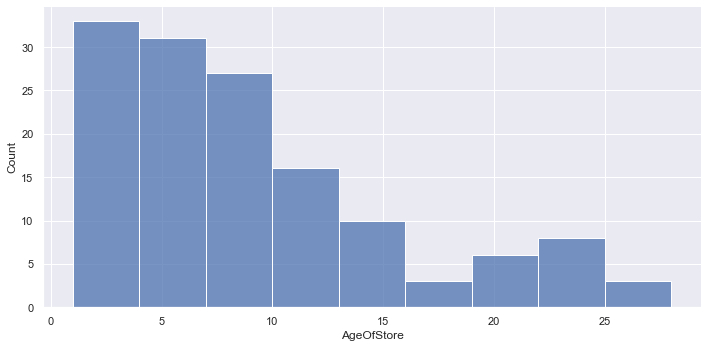

In [9]:
# Узнаем распределение возрастов магазинов:

sns.set_theme()
sns.displot(data=df, x='AgeOfStore', aspect=2)
sns.despine()

---

# Проведем разведывательный анализ:

1. Рассмотрим вначале как отличаются распределения продаж в разрезе только лишь по маркетинговым стратегии (Promotion):

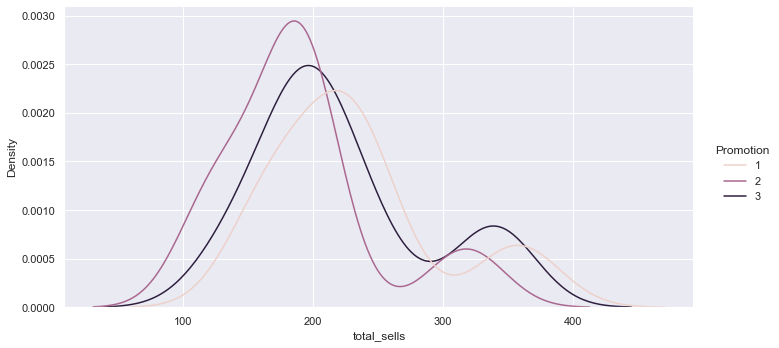

In [10]:
# На графиках распределения:

sns.set_theme()
sns.displot(data=df, x='total_sells', hue='Promotion',aspect=2, kind='kde')
sns.despine()

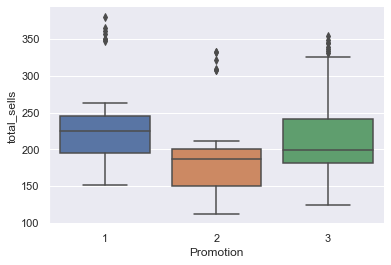

In [11]:
# На графиках боксплота:

sns.boxplot(x="Promotion", y="total_sells", data=df)
sns.despine()

In [12]:
# В терминах описательных статистик:

df.groupby('Promotion')\
  .agg({'total_sells':['count', 'mean','median', np.std]})

total_sells                               
                count        mean  median        std
Promotion                                           
1                  43  232.396047  224.30  64.112891
2                  47  189.317660  186.62  57.988389
3                  47  221.457872  199.41  65.535463

In [13]:
# Проводим тест на нормальность выборок:

for promo_number in df.Promotion.unique():
    print('Promotion {} имеет p-value: {}'.format(promo_number, shapiro(df[df.Promotion==promo_number].total_sells).pvalue))

Promotion 3 имеет p-value: 0.00013465984375216067
Promotion 2 имеет p-value: 2.3925502318888903e-05
Promotion 1 имеет p-value: 0.00015705579426139593


In [14]:
"""
Видим, что нулевая гипотеза о нормальности отклоняется для каждой выборки, 
тогда пробуем нормализовать их методом Бокса-Кокса.
Перебираем все возможные значения параметра lmbda и записываем для каждого - pvalue теста на нормальность:

"""

# Для Promotion = 1:
pvalues_1 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_1.append(shapiro(boxcox(df[df.Promotion==1].total_sells, 
                                    lmbda=lmbda)).pvalue)
    
# Для Promotion = 2:
pvalues_2 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_2.append(shapiro(boxcox(df[df.Promotion==2].total_sells, 
                                    lmbda=lmbda)).pvalue)

# Для Promotion = 3:
pvalues_3 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_3.append(shapiro(boxcox(df[df.Promotion==3].total_sells, 
                                    lmbda=lmbda)).pvalue)

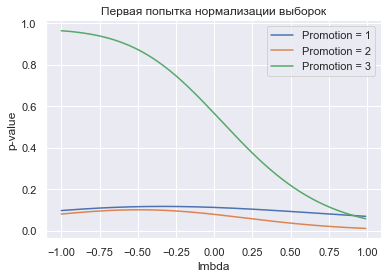

In [65]:
"""
Видим, что ни при каких значениях параметра lmbda, выборки не могут быть достоверно нормализованы 
(есть лишь небольшое превышение порога pvalue=0.05):

"""

plt.plot([i/100 for i in range(-100,100)], pvalues_1)
plt.plot([i/100 for i in range(-100,100)], pvalues_2)
plt.plot([i/100 for i in range(-100,100)], pvalues_3)

plt.title('Первая попытка нормализации выборок')
plt.legend(['Promotion = 1', 'Promotion = 2', 'Promotion = 3'])
plt.xlabel('lmbda')
plt.ylabel('p-value')

sns.despine()

In [66]:
"""
Попробуем повторить то же самое, исключив из выборок 1 максимальное и 1 минимальное значение (около 2% с каждой стороны)
Таким образом попробуем избавиться от влияния возможных выбросов:

"""

# Для Promotion = 1:
pvalues_1 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_1.append(shapiro(boxcox(df[df.Promotion==1].total_sells[1:-1:], 
                                    lmbda=lmbda)).pvalue)
    
# Для Promotion = 2:
pvalues_2 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_2.append(shapiro(boxcox(df[df.Promotion==2].total_sells[1:-1:],
                                    lmbda=lmbda)).pvalue)

# Для Promotion = 3:
pvalues_3 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_3.append(shapiro(boxcox(df[df.Promotion==3].total_sells[1:-1:], 
                                    lmbda=lmbda)).pvalue)

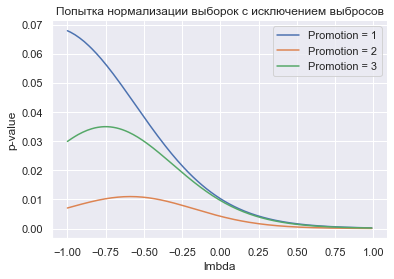

In [68]:
"""
Видим, что ни при каких значениях параметра lmbda, выборки все равно не могут быть достоверно нормализованы:
(cнова есть лишь небольшое превышение порога pvalue=0.05):

"""

plt.plot([i/100 for i in range(-100,100)], pvalues_1)
plt.plot([i/100 for i in range(-100,100)], pvalues_2)
plt.plot([i/100 for i in range(-100,100)], pvalues_3)

plt.title('Попытка нормализации выборок с исключением выбросов')
plt.legend(['Promotion = 1', 'Promotion = 2', 'Promotion = 3'])
plt.xlabel('lmbda')
plt.ylabel('p-value')

sns.despine()

In [18]:
# Проводим тест на гомогенность выборок:

samples = [df[df.Promotion==i].total_sells for i in df.Promotion.unique()]
levene(*samples)

LeveneResult(statistic=0.4681608444016786, pvalue=0.6271730417231256)

***Заключаем, что выборки не нормальны и гомогенны.***

In [19]:
# Проводим тест Краскала-Уоллиса (непараметрический аналог ANOVA) :

kruskal(*samples)

KruskalResult(statistic=17.327374531871044, pvalue=0.00017274617006801915)

***Заключаем, что есть хотя бы одна выборка статистически значимо отличающаяся от остальных, т.к. получившийся pvalue<0.05.***

---

2. Рассмотрим как отличаются распределения продаж в разрезе не только по маркетинговым стратегиям (Promotion), но и по другим факторам:

Сравнивать продажи в разрезе по слишком большому набору факторов тоже нельзя, т.к. в таком случае размеры получившихся выборок продаж за первые 4 недели могут сильно снизится до нерепрезентативных количеств, и тогда, даже если стат. значимое различие есть или нет, мы можем просто не смочь их обнаружить или сделаем ошибочный вывод. 

Поэтому, прежде чем далее сравнивать продажи в разрезах по нескольким факторам одновременно, узнаем какие комбинации (взаимодействиям) этих факторов вообще целесообразно рассматривать - в каких из них образовавшиеся размеры выборок будут репрезентативны.

Рассмотрим вначале взаимодействия из 2 факторов, один из которых - тип маркетинговой стратегии (Promotion), т.к. зависимость именно от нее нам интересна по заданию:

In [20]:
# Факторы - это названия столбцов (но с исключенным столбцом продаж, т.к. это зависимая переменная):

columns_without_sells = [col for col in df.columns if col!= 'total_sells']

In [21]:
# Создаем список взаимодействтий:

factor_combinations = []


# Комбинируем каждый столбец с каждым столбцом попарно:

for col1 in columns_without_sells:
    for col2 in columns_without_sells:
        
        if (col1!=col2 and col1=='Promotion') or (col1!=col2 and col2=='Promotion'):   # Взаимодействие должно включать неповторяющиеся столбцы и один из них должен быть Promotion

            combination = set([col1,col2])   # Пару записываем в виде множества, чтобы далее исключить повторы в списке взаимодействий
            
            if combination not in factor_combinations:   # Проверяем есть ли уже такая пара в списке взаимодействий (независимо от порядка внутри пары)
                factor_combinations.append(combination)  # Если пары нет - то добавляем в список

factor_combinations = list(map(lambda x: list(x), factor_combinations))   # Превращаем все пары из множества в список, чтобы далее подать в groupby

In [22]:
# Получаем 4 возможных взаимодействий двух факторов:

factor_combinations

[['Promotion', 'MarketID'],
 ['Promotion', 'MarketSize'],
 ['Promotion', 'LocationID'],
 ['Promotion', 'AgeOfStore']]

In [23]:
# Смотрим размеры образующихся выборок для взаимодействия ['Promotion', 'MarketID']:

df.groupby(['Promotion', 'MarketID'])\
  .agg({'total_sells':'count'})\
  .sort_values('total_sells')\
  .rename(columns={'total_sells':'sample_size'})\
  .head()

sample_size
Promotion MarketID             
1         2                   1
3         4                   1
1         5                   2
2         9                   2
          8                   2

In [24]:
# Смотрим размеры образующихся выборок для взаимодействия ['Promotion', 'MarketSize']:

df.groupby(['MarketSize', 'Promotion'])\
  .agg({'total_sells':'count'})\
  .sort_values('total_sells')\
  .rename(columns={'total_sells':'sample_size'})\
  .head()

sample_size
MarketSize Promotion             
Small      2                    4
           1                    5
           3                    6
Large      3                   12
           1                   14

In [25]:
# Смотрим размеры образующихся выборок для взаимодействия ['Promotion', 'AgeOfStore']:

df.groupby(['AgeOfStore', 'Promotion'])\
  .agg({'total_sells':'count'})\
  .sort_values('total_sells')\
  .rename(columns={'total_sells':'sample_size'})\
  .head()

,,sample_size
AgeOfStore,Promotion,
28,2,1
12,2,1
6,2,1
22,1,1
11,1,1


In [26]:
# Смотрим размеры образующихся выборок для взаимодействия ['Promotion','LocationID']:

df.groupby(['LocationID', 'Promotion'])\
  .agg({'total_sells':'count'})\
  .sort_values('total_sells')\
  .rename(columns={'total_sells':'sample_size'})\
  .head()

,,sample_size
LocationID,Promotion,
1,3,1
705,3,1
704,1,1
703,1,1
702,1,1


Видим, что для всех комбинаций, кроме одной, минимальный размер образовавшихся выборок продаж = 1. Это слишком мало - такие выборки нерепрезентативны. 

Поэтому для дальнейшего анализа мы можем отобрать только лишь комбинацию факторов: 'Promotion' и  'MarketSize', где минимальный размер выборки = 4.

Можем также попробовать применить биннинг значений возраста магазинов, т.к. эти данные непрерывные (continious). Разделим их на 3 квантиля и проверим минимальный размер образовавшихся выборок в комбинации с фактором 'Promotion':

In [69]:
# Делим возраста магазинов на 3 квантиля:
quantiles = df.AgeOfStore.quantile([0, 0.33333, 0.66666, 1]).values
quantiles[-1] = quantiles[-1]+0.1


# Назначаем названия получившихся категорий:
df['AgeOfStore_cat'] = pd.cut(df.AgeOfStore, quantiles, right=False, labels=['young', 'middle', 'old'])

df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,total_sells,AgeOfStore_cat
0,1,Medium,1,4,3,137.68,young
1,1,Medium,2,5,2,118.18,middle
2,1,Medium,3,12,1,162.72,old
3,1,Medium,4,1,2,134.83,young
4,1,Medium,5,10,2,116.01,old


In [70]:
# Количество магазинов в каждой категории равно:

df.AgeOfStore_cat.value_counts()

middle    47
old       46
young     44
Name: AgeOfStore_cat, dtype: int64

In [71]:
# Нет потерянных данных:

print('Непропущенных строк столбца AgeOfStore_cat: {}'.format(df.AgeOfStore_cat.dropna().shape[0]))
print('Было строк в изначальном датасете: {}'.format(df.shape[0]))

Непропущенных строк столбца AgeOfStore_cat: 137
Было строк в изначальном датасете: 137


In [72]:
# Узнаём какой минимальный размер образовавшихся выборок в комбинации с фактором 'Promotion':

df.groupby(['AgeOfStore_cat', 'Promotion'])\
  .agg({'total_sells':'count'})\
  .sort_values('total_sells')\
  .rename(columns={'total_sells':'sample_size'})\
  .head()

,,sample_size
AgeOfStore_cat,Promotion,
young,3,11
middle,1,13
old,1,14
middle,2,15
old,2,15


**Здесь также относительно приемлемые размеры выборок. Таким образом для дальнейшего рассмотрения отбираем взаимодействия:**

1. Promotion и AgeOfStore_cat
2. Promotion и MarketSize

---

3. Определим как отличаются распределения продаж у данных взаимодействий:

***3.1 Для взаимодействия Promotion и AgeOfStore_cat:***

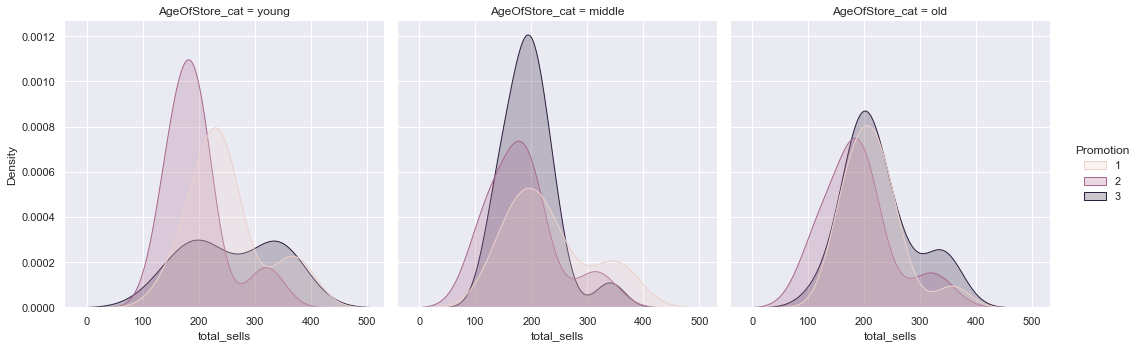

In [31]:
# На графиках распределения:

sns.set_theme()
sns.displot(data=df, x='total_sells', hue='Promotion', col='AgeOfStore_cat', kind='kde', fill=True)
sns.despine()

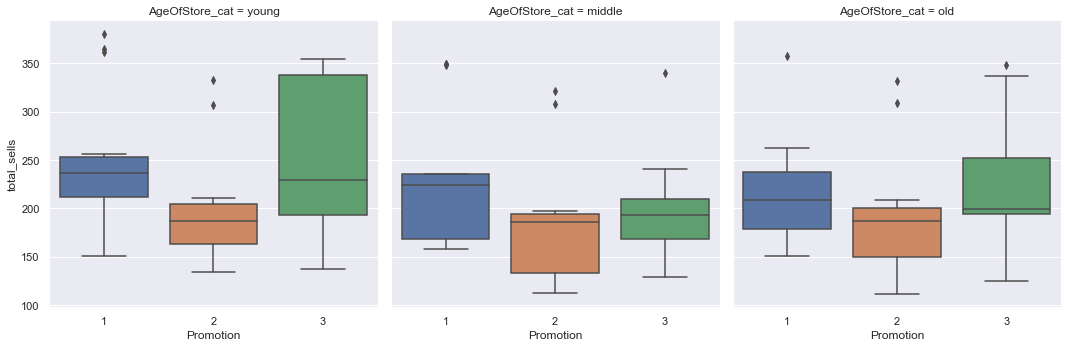

In [32]:
# На графиках боксплота:

sns.set_theme()
sns.catplot(data=df, x='Promotion', y='total_sells', col='AgeOfStore_cat', kind='box')
sns.despine()

In [33]:
# В терминах описательных статистик:

df.groupby(['AgeOfStore_cat', 'Promotion'])\
  .agg({'total_sells':['count','mean','median', np.std]}).sort_index()

total_sells                                
                               count        mean   median        std
AgeOfStore_cat Promotion                                            
young          1                  16  248.713125  236.215  65.933102
               2                  17  194.612941  186.620  52.878715
               3                  11  258.868182  229.300  81.427624
middle         1                  13  230.825385  223.900  72.830967
               2                  15  183.544000  186.400  62.171389
               3                  19  195.757895  192.860  47.653671
old            1                  14  215.206429  208.800  52.146869
               2                  15  189.090000  187.240  62.593980
               3                  17  225.974706  199.750  62.296675

In [77]:
# Создадим вспомогательный датафрейм и добавим новую колонку - объединение значений Promotion и AgeOfStore_cat:

df_1 = df.copy()
df_1['promo_and_age_cat'] = df_1.AgeOfStore_cat.astype(str)+'_'+df_1.Promotion.astype(str)
df_1.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,total_sells,AgeOfStore_cat,promo_and_age_cat
0,1,Medium,1,4,3,137.68,young,young_3
1,1,Medium,2,5,2,118.18,middle,middle_2
2,1,Medium,3,12,1,162.72,old,old_1
3,1,Medium,4,1,2,134.83,young,young_2
4,1,Medium,5,10,2,116.01,old,old_2


In [78]:
# Проводим тест на нормальность выборок:

for interaction in df_1.promo_and_age_cat.unique():
    print('Взаимодействие {} имеет p-value: {}'.format(interaction, 
                                                  shapiro(df_1[df_1.promo_and_age_cat==interaction].total_sells).pvalue))

Взаимодействие young_3 имеет p-value: 0.06961347162723541
Взаимодействие middle_2 имеет p-value: 0.011446213349699974
Взаимодействие old_1 имеет p-value: 0.05677679553627968
Взаимодействие young_2 имеет p-value: 0.0031421734020113945
Взаимодействие old_2 имеет p-value: 0.02379944920539856
Взаимодействие old_3 имеет p-value: 0.030832745134830475
Взаимодействие middle_1 имеет p-value: 0.010984020307660103
Взаимодействие middle_3 имеет p-value: 0.037661582231521606
Взаимодействие young_1 имеет p-value: 0.02218078263103962


In [79]:
"""
Видим, что нулевая гипотеза о нормальности отклоняется для каждой выборки, 
тогда пробуем нормализовать их методом Бокса-Кокса.
Перебираем все возможные значения параметра lmbda и записываем для каждого - pvalue теста на нормальность:

"""

# Для promo_and_age_cat = young_3:
pvalues_1 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_1.append(shapiro(boxcox(df_1[df_1.promo_and_age_cat=='young_3'].total_sells, 
                                    lmbda=lmbda)).pvalue)
    
# Для promo_and_age_cat = middle_2:
pvalues_2 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_2.append(shapiro(boxcox(df_1[df_1.promo_and_age_cat=='middle_2'].total_sells, 
                                    lmbda=lmbda)).pvalue)

# Для promo_and_age_cat = old_1:
pvalues_3 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_3.append(shapiro(boxcox(df_1[df_1.promo_and_age_cat=='old_1'].total_sells, 
                                    lmbda=lmbda)).pvalue)
    
# Для promo_and_age_cat = young_2:
pvalues_4 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_4.append(shapiro(boxcox(df_1[df_1.promo_and_age_cat=='young_2'].total_sells, 
                                    lmbda=lmbda)).pvalue)
    
# Для promo_and_age_cat = old_2:
pvalues_5 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_5.append(shapiro(boxcox(df_1[df_1.promo_and_age_cat=='old_2'].total_sells, 
                                    lmbda=lmbda)).pvalue)
    
# Для promo_and_age_cat = old_3
pvalues_6 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_6.append(shapiro(boxcox(df_1[df_1.promo_and_age_cat=='old_3'].total_sells, 
                                    lmbda=lmbda)).pvalue)
# Для promo_and_age_cat = middle_1:
pvalues_7 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_7.append(shapiro(boxcox(df_1[df_1.promo_and_age_cat=='middle_1'].total_sells, 
                                    lmbda=lmbda)).pvalue)
    
# Для promo_and_age_cat = middle_3:
pvalues_8 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_8.append(shapiro(boxcox(df_1[df_1.promo_and_age_cat=='middle_3'].total_sells, 
                                    lmbda=lmbda)).pvalue)
    
# Для promo_and_age_cat = young_1:
pvalues_9 = []
for i in range(-100,100):
    lmbda = i/100
    pvalues_9.append(shapiro(boxcox(df_1[df_1.promo_and_age_cat=='young_1'].total_sells, 
                                    lmbda=lmbda)).pvalue)

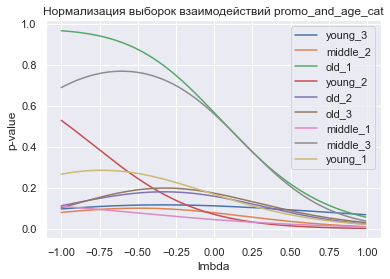

In [80]:
# Видим, что ни при каких значениях параметра lmbda, выборки не могут быть достоверно нормализованы 
# (есть лишь небольшое превышение порога pvalue=0.05):

plt.plot([i/100 for i in range(-100,100)], pvalues_1)  
plt.plot([i/100 for i in range(-100,100)], pvalues_2)
plt.plot([i/100 for i in range(-100,100)], pvalues_3)
plt.plot([i/100 for i in range(-100,100)], pvalues_4)
plt.plot([i/100 for i in range(-100,100)], pvalues_5)
plt.plot([i/100 for i in range(-100,100)], pvalues_6)
plt.plot([i/100 for i in range(-100,100)], pvalues_7)
plt.plot([i/100 for i in range(-100,100)], pvalues_8)
plt.plot([i/100 for i in range(-100,100)], pvalues_9)

plt.title('Нормализация выборок взаимодействий promo_and_age_cat')
plt.legend(df_1.promo_and_age_cat.unique())
plt.xlabel('lmbda')
plt.ylabel('p-value')

sns.despine()

In [81]:
"""
Приходим к выводу, что для всех выборок при lmbda=-0.75 нет оснований отклонять нулевую гипотезу о нормальности.
Проверим данное утверждение еще раз.
Видим, что скорректированные выборки имеют p-value теста на нормальность более 0.05:

"""

for interaction in df_1.promo_and_age_cat.unique():
    boxcoxed = boxcox(df_1[df_1.promo_and_age_cat==interaction].total_sells, lmbda=-0.75)
    
    print('Взаимодействие {} имеет p-value: {}'.format(interaction, 
                                                  shapiro(boxcoxed).pvalue))

Взаимодействие young_3 имеет p-value: 0.10991887003183365
Взаимодействие middle_2 имеет p-value: 0.09564363956451416
Взаимодействие old_1 имеет p-value: 0.9397796988487244
Взаимодействие young_2 имеет p-value: 0.3850120007991791
Взаимодействие old_2 имеет p-value: 0.14968179166316986
Взаимодействие old_3 имеет p-value: 0.15421146154403687
Взаимодействие middle_1 имеет p-value: 0.09547948837280273
Взаимодействие middle_3 имеет p-value: 0.7570444345474243
Взаимодействие young_1 имеет p-value: 0.28617897629737854


In [86]:
# Проводим тест на гомогенность скорректированных выборок:

samples = [boxcox(df_1[df_1.promo_and_age_cat==i].total_sells, lmbda=-0.75) for i in df_1.promo_and_age_cat.unique()]
levene(*samples)

LeveneResult(statistic=0.7722195754791844, pvalue=0.6278315740360212)

***Заключаем, что скорректированные выборки нормальны и гомогенны.***

In [100]:
"""
Проводим однофакторный дисперсионный анализ (непараметрический аналог ANOVA) 
скорректированных методом Бокса-Кокса данных продаж в разрезе по каждой 
категории возраста магазина:
"""

for age_cat in df_1.AgeOfStore_cat.unique():
    
    samples = [ boxcox(df_1[df_1.promo_and_age_cat==i].total_sells, lmbda=-0.75) for i in df_1.promo_and_age_cat.unique() \
                if age_cat in i]
    
    
    
    pvalue = f_oneway(*samples).pvalue
    print('Выборкам продаж c AgeOfStore_cat={} соответствует p-value дисперсионного анализа: {}'.format(age_cat, pvalue))


Выборкам продаж c AgeOfStore_cat=young соответствует p-value дисперсионного анализа: 0.014244596511611082
Выборкам продаж c AgeOfStore_cat=middle соответствует p-value дисперсионного анализа: 0.07678866007890428
Выборкам продаж c AgeOfStore_cat=old соответствует p-value дисперсионного анализа: 0.08684243609839101


***Заключаем, что для каждой категории возраста магазина существует хотя бы 1 тип маркетинговой страгтегии (Promotion), который стат. значимо отличающиеся от остальных по объёмам продаж в первые 4 недели. Однако эта разница во всех случаях, скорее всего, несущественна т.к. все три получившихся p-value не сильно меньше 0.05.***

---

***3.2 Для взаимодействия Promotion и MarketSize:***

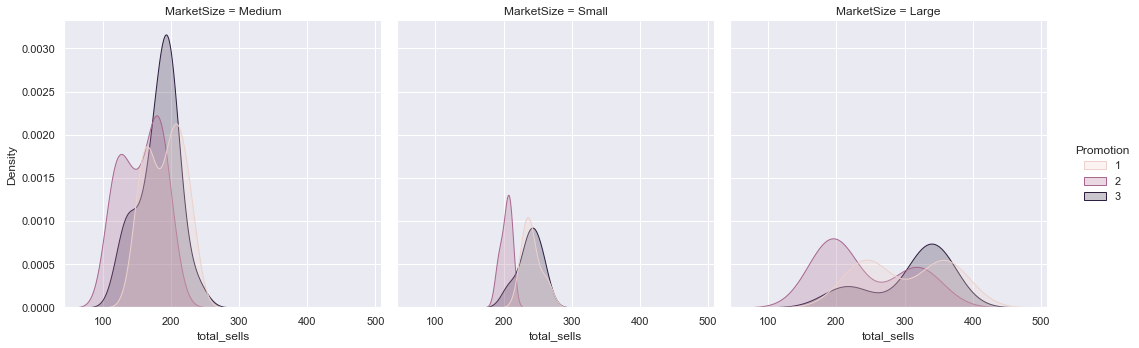

In [41]:
# На графиках распределения:

sns.set_theme()
sns.displot(data=df, x='total_sells', hue='Promotion', col='MarketSize', kind='kde', fill=True)
sns.despine()

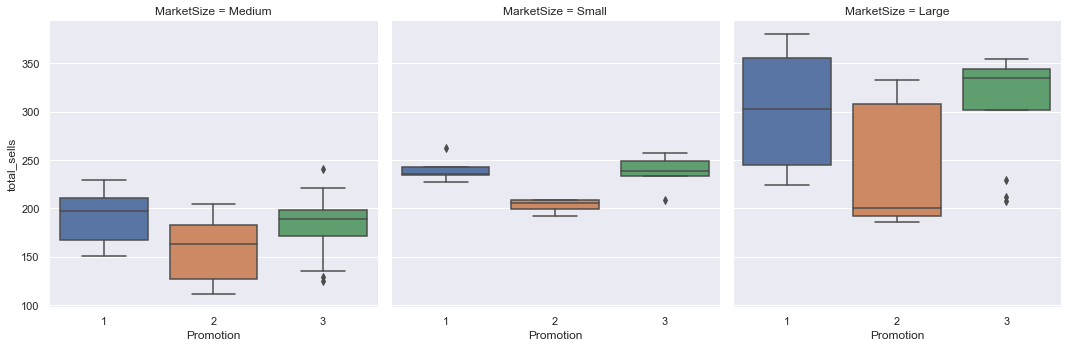

In [42]:
# На графиках боксплота:

sns.set_theme()
sns.catplot(data=df, x='Promotion', y='total_sells', col='MarketSize', kind='box')
sns.despine()

In [43]:
# В терминах описательных статистик:

df.groupby(['MarketSize', 'Promotion'])\
  .agg({'total_sells':['count','mean','median', np.std]}).sort_index()

total_sells                                
                           count        mean   median        std
MarketSize Promotion                                            
Large      1                  14  300.943571  302.200  60.764873
           2                  16  241.288125  200.660  62.323645
           3                  12  308.815833  334.965  56.600475
Medium     1                  24  190.690417  197.625  26.425110
           2                  27  156.457407  163.720  29.800368
           3                  29  181.875517  188.660  28.143485
Small      1                   5  240.650000  235.550  13.323755
           2                   4  203.242500  205.645   7.829859
           3                   6  238.056667  238.650  17.214765

In [45]:
# Создадим вспомогательный датафрейм и добавим новую колонку - объединение значений Promotion и AgeOfStore_cat:

df_2 = df.copy()
df_2['promo_and_marketsize'] = df_2.MarketSize.astype(str)+'_'+df_2.Promotion.astype(str)
df_2.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,total_sells,AgeOfStore_cat,promo_and_marketsize
0,1,Medium,1,4,3,137.68,young,Medium_3
1,1,Medium,2,5,2,118.18,middle,Medium_2
2,1,Medium,3,12,1,162.72,old,Medium_1
3,1,Medium,4,1,2,134.83,young,Medium_2
4,1,Medium,5,10,2,116.01,old,Medium_2


In [55]:
# Проводим тест на гомогенность выборок:

samples = [ df_2[df_2.promo_and_marketsize==i].total_sells for i in df_2.promo_and_marketsize.unique()]

levene(*samples)

LeveneResult(statistic=4.499689051391032, pvalue=7.75224887124516e-05)

In [62]:
"""
Видим, что нельзя говорить о гомогенности всех выборок одновременно. Обращаемся к боксполтам (выше) и замечаем, что 
изменчивость данных примерно одинакова внутри отдельных значений MarketSize. Тогда проверим гипотезу, что выборки гомогенны
внутри одного типа MarketSize:

"""

for size_type in df_2.MarketSize.unique():
    samples = [ df_2[df_2.promo_and_marketsize==i].total_sells for i in df_2.promo_and_marketsize.unique() \
                if size_type in i]
    pvalue = levene(*samples).pvalue
    print('Выборкам MarketSize={} соответствует p-value гипотезы гомогенности: {}'.format(size_type, pvalue))

Выборкам MarketSize=Medium соответствует p-value гипотезы гомогенности: 0.5317541131352252
Выборкам MarketSize=Small соответствует p-value гипотезы гомогенности: 0.608640310822746
Выборкам MarketSize=Large соответствует p-value гипотезы гомогенности: 0.4525212685151805


**Таким образом, видим, что условие гомогенности выполняется для выборок внутри каждого отдельного типа MarketSize. Поэтому в дальнейшем также будем рассматривать их в отдельности.**

***Заключаем, что выборки в разрезе по каждому типу MarketSize не нормальны и гомогенны. Тогда применим отдельно для выборок внутри каждого типа MarketSize непараметрический аналог ANOVA - критерий Краскала-Уоллиса.***

In [101]:
for size_type in df_2.MarketSize.unique():
    samples = [ df_2[df_2.promo_and_marketsize==i].total_sells for i in df_2.promo_and_marketsize.unique() \
                if size_type in i]
    
    pvalue = kruskal(*samples).pvalue
    print('Выборкам с MarketSize={} соответствует p-value теста Краскала-Уоллиса: {}'.format(size_type, pvalue))

Выборкам с MarketSize=Medium соответствует p-value теста Краскала-Уоллиса: 0.0004026880364685163
Выборкам с MarketSize=Small соответствует p-value теста Краскала-Уоллиса: 0.03282165832666328
Выборкам с MarketSize=Large соответствует p-value теста Краскала-Уоллиса: 0.001007122001436089


***Заключаем, что внутри каждого типа MarketSize существует хотя бы 1 тип маркетинговой страгтегии (Promotion), который стат. значимо отличающиеся от остальных по объёмам продаж в первые 4 недели.***

---

# Формулировка гипотезы.

Резюмируя разведывательный анализ, мы получили, что:

1. Хотя бы 1 тип маркетинговой стратегии (Promotion) дает стат. знач. отличный от остальных объем продаж в первые 4 недели, если судить в разрезе только по типам маркетинговых стратегий (Promotion).


2. Хотя бы 1 тип маркетинговой стратегии (Promotion) дает стат. знач. отличный от остальных объем продаж в первые 4 недели, если судить в разрезе по категории возраста магазина (AgeOfStore_cat: young, middle, old).


3. Хотя бы 1 тип маркетинговой стратегии (Promotion) дает стат. знач. отличный от остальных объем продаж в первые 4 недели, если судить в разрезе по размеру рынка (MarketSize).

Чтобы в будущем сделать однозначный вывод о том, какую маректинговую стратегию необходимо выбрать каждому магазину для максимизации продаж в первые 4 недели, нам необходимо выбрать только одну гипотезу для дальнейшей проверки - дающую наиболее существенные различия между результатами продаж.

Обратимся для этого к результатам разведывательного анализа:

1. Для разреза только по типам маректинговой стратегии (Promotion):


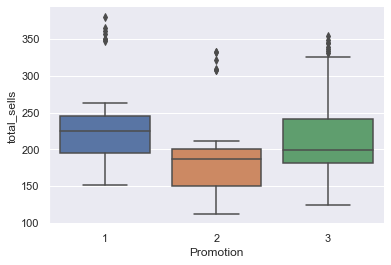

In [103]:
# Боксплоты продаж получились:

sns.boxplot(x="Promotion", y="total_sells", data=df)
sns.despine()

Видим, что "усы" синего боксплота полностью перекрываются зеленым. То есть между 1 и 3 стратегиями нет стат. знач. разницы. Вто же время медиана оранжевого боксплота находится ниже и синего и зеленого, но сам боксплот почти полностью перекрывается зеленым. Это говорит о том, что между 2 и 3 стратегиями тоже ,скорее всего, нет стат. знач. разницы.

In [104]:
# Описательные статистики рез-тов продаж получились:

df.groupby('Promotion')\
  .agg({'total_sells':['count', 'mean','median', np.std]})

total_sells                               
                count        mean  median        std
Promotion                                           
1                  43  232.396047  224.30  64.112891
2                  47  189.317660  186.62  57.988389
3                  47  221.457872  199.41  65.535463

In [129]:
# Разница медиан объемов продаж в первые 4 недели:

print('Медиана числа продаж 2 стратегии на {} % ниже, чем у 1'.format( round((224-186)*100/224)) )
print('Медиана числа продаж 2 стратегии на {} % ниже, чем у 3'.format( round((199-186)*100/199)) )
print('Медиана числа продаж 3 стратегии на {} % ниже, чем у 1'.format( round((224-199)*100/224)) )

Медиана числа продаж 2 стратегии на 17 % ниже, чем у 1
Медиана числа продаж 2 стратегии на 7 % ниже, чем у 3
Медиана числа продаж 3 стратегии на 11 % ниже, чем у 1


In [117]:
# Результат теста Краскела-Уоллиса:

print('pvalue=0.00017274617006801915')

pvalue=0.00017274617006801915


2. Для разреза по категории возраста магазина (AgeOfStore_cat: young, middle, old):

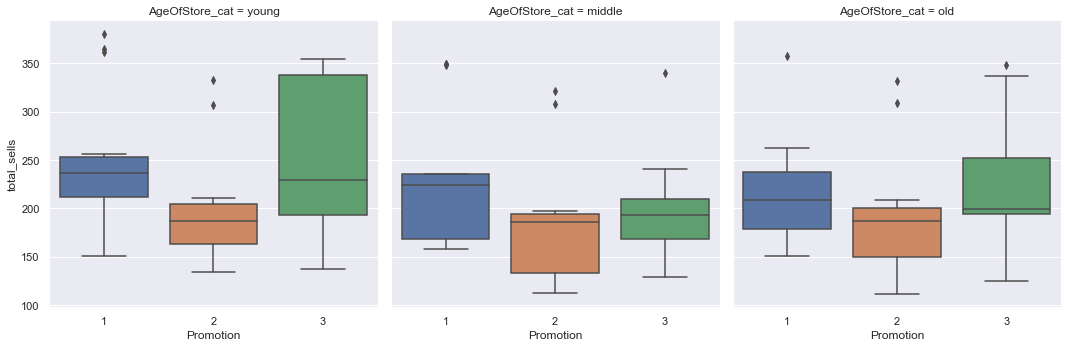

In [116]:
# Боксплоты продаж получились:

sns.set_theme()
sns.catplot(data=df, x='Promotion', y='total_sells', col='AgeOfStore_cat', kind='box')
sns.despine()

Видим, что во всех случаях "усы" синего боксплота полностью перекрываются зеленым. Это также означает, что между продажами после 1 и 3 стратегиями нет стат. значимой разницы ни для одной категории возраста магазина. В то же время 2 стратегия также показывает более низкие рез-ты продаж по сравнению с остальными. Однако медиана продаж не сильно отличается у 2 и 3 в каждой категории возраста магазина. Также "усы" боксплота второй стратегии не сильно выходят за пределы "усов" 3 стратегии , это означает, что скорее всего, разница в продажах после 2 и 3 стратегий практически не отличается стат. значимо.

In [130]:
# Описательные статистики рез-тов продаж получились:

df.groupby(['AgeOfStore_cat', 'Promotion'])\
  .agg({'total_sells':['count','mean','median', np.std]}).sort_index()

total_sells                                
                               count        mean   median        std
AgeOfStore_cat Promotion                                            
young          1                  16  248.713125  236.215  65.933102
               2                  17  194.612941  186.620  52.878715
               3                  11  258.868182  229.300  81.427624
middle         1                  13  230.825385  223.900  72.830967
               2                  15  183.544000  186.400  62.171389
               3                  19  195.757895  192.860  47.653671
old            1                  14  215.206429  208.800  52.146869
               2                  15  189.090000  187.240  62.593980
               3                  17  225.974706  199.750  62.296675

In [142]:
# Разница медиан объемов продаж в первые 4 недели:

print('Макисмальная разница медиан продаж для AgeOfStore_cat={}: {}%'.format('young', round((229-186)*100/229)))
print('Макисмальная разница медиан продаж для AgeOfStore_cat={}: {}%'.format('middle', round((192-186)*100/192)))
print('Макисмальная разница медиан продаж для AgeOfStore_cat={}: {}%'.format('old', round((199-187)*100/199)))

Макисмальная разница медиан продаж для AgeOfStore_cat=young: 19%
Макисмальная разница медиан продаж для AgeOfStore_cat=middle: 3%
Макисмальная разница медиан продаж для AgeOfStore_cat=old: 6%


In [122]:
# Результаты дисперсионного анализа для каждой категории возраста магазина:

print('Выборкам продаж c AgeOfStore_cat=young соответствует p-value дисперсионного анализа: 0.014244596511611082')
print('Выборкам продаж c AgeOfStore_cat=middle соответствует p-value дисперсионного анализа: 0.07678866007890428')
print('Выборкам продаж c AgeOfStore_cat=old соответствует p-value дисперсионного анализа: 0.08684243609839101')

Выборкам продаж c AgeOfStore_cat=young соответствует p-value дисперсионного анализа: 0.014244596511611082
Выборкам продаж c AgeOfStore_cat=middle соответствует p-value дисперсионного анализа: 0.07678866007890428
Выборкам продаж c AgeOfStore_cat=old соответствует p-value дисперсионного анализа: 0.08684243609839101


---

3. Для разреза по размеру рынка (MarketSize):

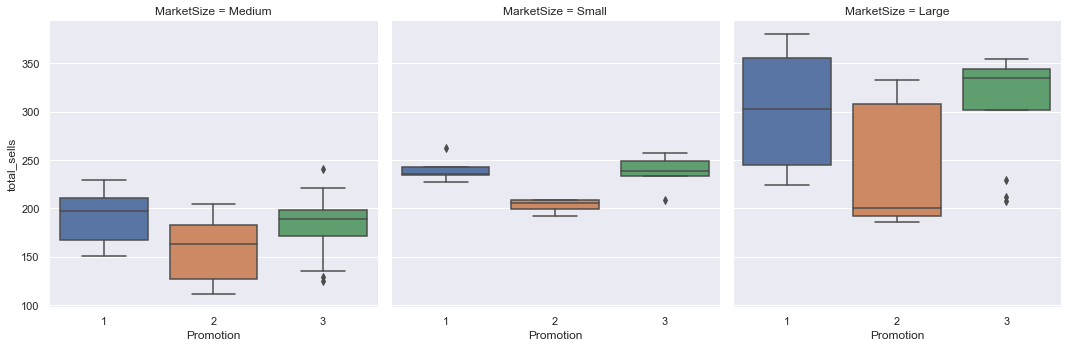

In [123]:
# Боксплоты продаж получились:

sns.set_theme()
sns.catplot(data=df, x='Promotion', y='total_sells', col='MarketSize', kind='box')
sns.despine()

Видим, что во всех случаях "усы" синего и зеленого боксплота полностью перекрываются друг другом. Это также означает, что между продажами после 1 и 3 стратегиями нет стат. значимой разницы ни для одной категории размера рынка магазина (MarketSize).  В то же время наблюдается отсутствие перекрытия "усов" боксплота продаж 2 стратегии с усами какой-либо другой стратегии при MarketSize=Small , однако это может вызываться тем, что размеры этих выборок слишком малы и данные нерепрезентативны.

In [125]:
# Описательные статистики рез-тов продаж получились:

df.groupby(['MarketSize', 'Promotion'])\
  .agg({'total_sells':['count','mean','median', np.std]}).sort_index()

total_sells                                
                           count        mean   median        std
MarketSize Promotion                                            
Large      1                  14  300.943571  302.200  60.764873
           2                  16  241.288125  200.660  62.323645
           3                  12  308.815833  334.965  56.600475
Medium     1                  24  190.690417  197.625  26.425110
           2                  27  156.457407  163.720  29.800368
           3                  29  181.875517  188.660  28.143485
Small      1                   5  240.650000  235.550  13.323755
           2                   4  203.242500  205.645   7.829859
           3                   6  238.056667  238.650  17.214765

In [141]:
# Разница медиан объемов продаж в первые 4 недели:

print('Макисмальная разница медиан продаж для MarketSize={}: {}%'.format('Large', round((302-200)*100/302)))
print('Макисмальная разница медиан продаж для MarketSize={}: {}%'.format('Medium', round((188-163)*100/188)))
print('Макисмальная разница медиан продаж для MarketSize={}: {}%'.format('Small', round((235-205)*100/235)))

Макисмальная разница медиан продаж для MarketSize=Large: 34%
Макисмальная разница медиан продаж для MarketSize=Medium: 13%
Макисмальная разница медиан продаж для MarketSize=Small: 13%


In [128]:
# Результаты теста Краскала-Уоллиса для каждого типа MarketSize магазина:

print('MarketSize=Small соответствует p-value: 0.03282165832666328')
print('MarketSize=Medium соответствует p-value: 0.0004026880364685163')
print('MarketSize=Large соответствует p-value: 0.001007122001436089')

MarketSize=Small соответствует p-value: 0.03282165832666328
MarketSize=Medium соответствует p-value: 0.0004026880364685163
MarketSize=Large соответствует p-value: 0.001007122001436089


***В результате можем заключать, что наиболее существенные различия в объемах продаж первых 4 недель наблюдаются между маркетинговыми стратегиями внутри отделенных типов рынка (MarketSize). То есть взаимодействия фактора Promotion и MarketSize.***

**Делаем гипотезу, что:**

1. Выбор 2 маркетинговой стратегии дает на 34% меньшие объемы продаж в первые 4 месяца после проведения, чем у 1 и 3 стратегий в магазинах с MarketSize=Large.

2. Выбор 2 маркетинговой стратегии дает на 13% меньшие объемы продаж в первые 4 месяца после проведения, чем у 1 и 3 стратегий в магазинах с MarketSize=Small и Medium.

# Проверка гипотезы (анализ).

Ранее получили, что внутри каждого типа MarketSize выборки продаж в первые 4 недели в зависимости от стратегии гомогенны и ненормальны.

Т.к. условие нормальности выполнить не удалось, для каждого типа MarketSize проводим попарный тест Данна для выборок продаж, соответствующих разным маркетинговым стратегиям (Promotion):

In [144]:
df.MarketSize.unique()

array(['Medium', 'Small', 'Large'], dtype=object)

1. MarketSize = 'Small'

In [158]:
# Датасет с выборками продаж, соответствующими разным маркетинговым стратегиям:

samples_df = df.query("MarketSize=='Small'")\
               .groupby('Promotion')\
               .agg({'total_sells':lambda x: x.to_list()})\
               .rename(columns={'total_sells':'sample_list'})
samples_df

,sample_list
Promotion,
1,"[262.40000000000003, 235.55, 234.75, 242.97, 2..."
2,"[209.04, 202.25, 192.54, 209.14]"
3,"[241.15, 257.36, 252.07, 233.14, 236.15, 208.4..."


In [166]:
# Список выборок:

samples = samples_df.sample_list.to_list()

In [178]:
# Строим таблицу p-value того, что стратегии (promo) на пересечнии - дают стат. значимо не различные выборки продаж:

dunn_table = sp.posthoc_dunn(samples)
dunn_table.index = ['Promotion_1', 'Promotion_2', 'Promotion_3']
dunn_table.columns = ['Promotion_1', 'Promotion_2', 'Promotion_3']
dunn_table

,Promotion_1,Promotion_2,Promotion_3
Promotion_1,1.000000,0.019631,0.902035
Promotion_2,0.019631,1.000000,0.020921
Promotion_3,0.902035,0.020921,1.000000


In [179]:
# Таким образом, если p-value<0.05, то принимаем, что данные выборки продаж стат. значимо различны:

dunn_table<0.05

,Promotion_1,Promotion_2,Promotion_3
Promotion_1,False,True,False
Promotion_2,True,False,True
Promotion_3,False,True,False


**Получаем стат. значимые отличия объемов продаж для между маркетинговыми стратегиями 1 и 2 ; 3 и 2. Стратегии 1 и 3 не дают стат. значимого различия в продажах.**

2. MarketSize = 'Medium'

In [180]:
# Датасет с выборками продаж, соответствующими разным маркетинговым стратегиям:

samples_df = df.query("MarketSize=='Medium'")\
               .groupby('Promotion')\
               .agg({'total_sells':lambda x: x.to_list()})\
               .rename(columns={'total_sells':'sample_list'})
samples_df

,sample_list
Promotion,
1,"[162.72, 172.97000000000003, 158.06, 151.14, 1..."
2,"[118.18, 134.82999999999998, 116.0099999999999..."
3,"[137.68, 124.74000000000001, 145.45, 196.16, 1..."


In [181]:
# Список выборок:

samples = samples_df.sample_list.to_list()

In [186]:
# Строим таблицу p-value того, что стратегии (promo) на пересечнии - дают стат. значимо не различные выборки продаж:

dunn_table = sp.posthoc_dunn(samples)
dunn_table.index = ['Promotion_1', 'Promotion_2', 'Promotion_3']
dunn_table.columns = ['Promotion_1', 'Promotion_2', 'Promotion_3']
dunn_table

,Promotion_1,Promotion_2,Promotion_3
Promotion_1,1.000000,0.000782,0.772882
Promotion_2,0.000782,1.000000,0.003482
Promotion_3,0.772882,0.003482,1.000000


In [183]:
# Таким образом, если p-value<0.05, то принимаем, что данные выборки продаж стат. значимо различны:

dunn_table<0.05

,Promotion_1,Promotion_2,Promotion_3
Promotion_1,False,True,False
Promotion_2,True,False,True
Promotion_3,False,True,False


**Также получаем стат. значимые отличия объемов продаж для между маркетинговыми стратегиями 1 и 2 ; 3 и 2. Стратегии 1 и 3 не дают стат. значимого различия в продажах.**

2. MarketSize = 'Large'

In [184]:
# Датасет с выборками продаж, соответствующими разным маркетинговым стратегиям:

samples_df = df.query("MarketSize=='Large'")\
               .groupby('Promotion')\
               .agg({'total_sells':lambda x: x.to_list()})\
               .rename(columns={'total_sells':'sample_list'})
samples_df

,sample_list
Promotion,
1,"[349.66, 380.36, 357.05, 349.5, 364.5, 361.37,..."
2,"[332.63000000000005, 331.78999999999996, 307.2..."
3,"[325.23, 333.36, 348.27, 336.57, 344.65, 354.3..."


In [185]:
# Список выборок:

samples = samples_df.sample_list.to_list()

In [187]:
# Строим таблицу p-value того, что стратегии (promo) на пересечнии - дают стат. значимо не различные выборки продаж:

dunn_table = sp.posthoc_dunn(samples)
dunn_table.index = ['Promotion_1', 'Promotion_2', 'Promotion_3']
dunn_table.columns = ['Promotion_1', 'Promotion_2', 'Promotion_3']
dunn_table

,Promotion_1,Promotion_2,Promotion_3
Promotion_1,1.000000,0.000782,0.772882
Promotion_2,0.000782,1.000000,0.003482
Promotion_3,0.772882,0.003482,1.000000


In [188]:
# Таким образом, если p-value<0.05, то принимаем, что данные выборки продаж стат. значимо различны:

dunn_table<0.05

,Promotion_1,Promotion_2,Promotion_3
Promotion_1,False,True,False
Promotion_2,True,False,True
Promotion_3,False,True,False


**Также получаем стат. значимые отличия объемов продаж для между маркетинговыми стратегиями 1 и 2 ; 3 и 2. Стратегии 1 и 3 не дают стат. значимого различия в продажах.**

# Вывод.

Гипотезы подтвердились.

Можно говорить, что в рамках данного эксперимента со статистической значимостью 95% можно заключить, что:

1. Выбор 2 маркетинговой стратегии дает на 34% меньшие объемы продаж в первые 4 месяца после проведения, чем у 1 и 3 стратегий в магазинах с MarketSize=Large.

2. Выбор 2 маркетинговой стратегии дает на 13% меньшие объемы продаж в первые 4 месяца после проведения, чем у 1 и 3 стратегий в магазинах с MarketSize=Small и Medium.

Таким образом мы получили, что независимо от размера рынка магазина (MarketSize) 1 и 3 маркетинговая стратегии работают лучше, чем 2. Нашей сети магазинов фаст-фуда необходимо далее сфокусироваться на этих двух стартегиях и исключить вторую из дальнейших кампаний.